### Strategy-Independent Bet Sizing Approaches

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from FinancialMachineLearning.labeling.labeling import *
from datetime import timedelta

warnings.filterwarnings('ignore')

triple_barrier_event = pd.read_parquet('../../Data/AAPL_triple_barrier_events.parquet')
avg_uniqueness = pd.read_parquet('../../Data/AAPL_avg_unique.parquet')
feature_matrix = pd.read_parquet('../../Data/AAPL_feature_matrix.parquet')

labels = meta_labeling(
    triple_barrier_event, 
    feature_matrix['Close']
)
triple_barrier_event['side'] = labels['bin']
meta_labels = meta_labeling(
    triple_barrier_event, # with side labels
    feature_matrix['Close']
)

동일한 상품에 대한 두 가지 전략을 고려해 보자. $m_{i,t} \in [-1, 1]$을 시점 $t$에서의 전략 $i$의 베팅 크기라고 하자. 여기서 $m_{i,t} = -1$은 완전 short position, $m_{i,t} = 1$은 완전 long position을 뜻한다. 전략 하나가 베팅 크기 시퀀스로 $[m_{1,1}, m_{1,2}, m_{1,3}] = [0.5, 1, 0]$을 생성했고, 시장가는 $[p_1, p_2, p_3] = [1, 0.5, 1.25]$라고 하자. 여기서 $p_t$는 시점 $t$에서의 가격이다. 또 다른 전략은 금융 시장이 초기 포지션에 반대로 움직일 경우 베팅을 줄이도록 했기 때문에 $[m_{2,1}, m_{2,2}, m_{2,3}] = [1, 0.5, 0]$을 생성했다. 양쪽 전략 모두 정확히 예측했다. 처음 전략은 이익(0.5)을 냈지만, 두 번째 전략은 손실(-0.125)이 발생했다.

거래 신호가 약해지기 전에 그 신호가 강해질 가능성에 대비해 현금을 확보할 수 있도록 포지션의 크기를 정하는 것을 추천한다. 선택할 수 있는 방법 중 하나는 계열 $c_t = c_{t,l} - c_{t, s}$를 계산하는 것인데, 여기서 $c_{t,l}$은 시점 $t$에서 공존하는 long betting 개수, $c_{t,s}$는 시점 $t$에서 공존하는 short betting 개수이다. 여기서의 bet concurrency는 각 방향에 대해 Chapter 4에서 Label Concurrency를 계산한 것과 비슷한 방법으로 도출되었다. Lopez de Prado & Foreman(2014)에서 설명한 것과 같은 방법을 이용해 $\{c_t\}$에 두개의 Gaussian 분포를 혼합한 것을 적용한다. 그러면 베팅 크기가 다음과 같이 유도된다.

$$
m_t =
\begin{cases}
\frac{F[c_t] - F[0]}{1 - F[0]} & \text{ if } c_t \geq 0\\
\frac{F[c_t] - F[0]}{F[0]} & \text{ if } c_t \leq 0
\end{cases}
$$

여기서 $F[x]$는 값 $x$에 대한 두 혼합 Gaussian 분포의 적합화된 누적 분포 함수이다. 예를 들어, 더 큰 값의 신호를 관찰할 확률이 단지 0.1일 때 베팅의 크기를 0.9로 설정할 수 있다. 신호가 강해질수록 신호가 더 강해질 확률은 점점 작아지므로 이에 따라 베팅의 크기는 더 커진다. 

In [26]:
from FinancialMachineLearning.bet_sizing.bet_sizing import bet_size_reserve

reserve_bet_size = bet_size_reserve(
    events_t1 = triple_barrier_event['t1'],
    sides = triple_barrier_event['side'],
    fit_runs = 100,
    epsilon = 1e-5,
    factor = 5,
    variant = 2,
    max_iter = 1000,
    num_workers = 1,
    return_parameters = False
)

|#########################| Completed 100 of 100 fitting rounds.

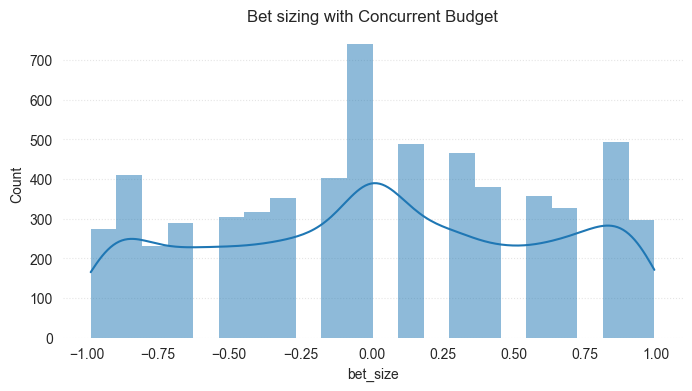

In [29]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.histplot(
    reserve_bet_size['bet_size'], 
    ax = ax, 
    edgecolor = 'none', 
    kde = True
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Bet sizing with Concurrent Budget')
plt.show()

두 번째 방법은 예산 관리 방식을 따르는 것이다. Concurrent Long Betting의 최대 개수 $\max_i \{c_{i,s}\}$를 계산한다. 그런 다음 베팅의 크기를 다음과 같이 유도한다.

$$m_t = c_{t,l} \frac{1}{\max_i \{c_{i,l}\}} - c_{t,s}\frac{1}{\max_i \{c_{i,s}\}}$$

여기서 $c_{t,l}$은 시점 $t$에서의 Concurrent Long Betting 개수, $c_{t,s}$는 시점 $t$에서의 Concurrent Short Betting의 개수이다. 목표는 마지막 Concurrent signal이 발생하기 전에 최대 포지션에 도달하지 않도록 하는 것이다.

In [18]:
from FinancialMachineLearning.bet_sizing.bet_sizing import bet_size_budget

budget_bet = bet_size_budget(
    events_t1 = triple_barrier_event['t1'],
    sides = triple_barrier_event['side']
)

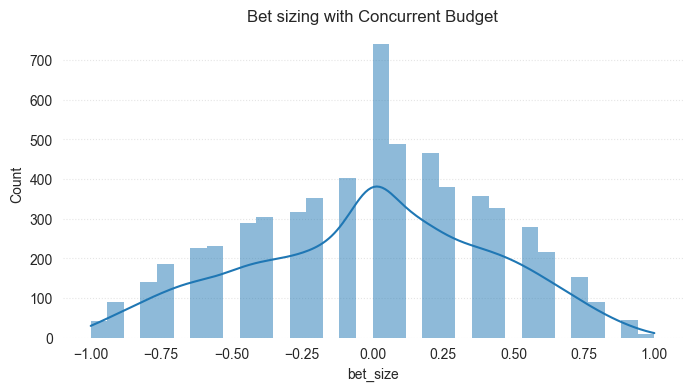

In [30]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.histplot(
    budget_bet['bet_size'], 
    ax = ax, 
    edgecolor = 'none', 
    kde = True
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Bet sizing with Concurrent Budget')
plt.show()

세 번째 방법은 Chapter 3에서 설명한 Meta Labeling을 적용하는 것이다. SVC나 Random Forest같은 분류기를 적합화해 분류 확률을 결정하고, 이 확률을 사용해 베팅 크기를 도출한다. 이 방법은 몇 가지 장점이 있다. 첫째, 베팅 크기를 결정하는 Machine Learning Algorithm은 Primary Model과 독립적이어서 거짓 양의 전조가 되는 특성을 포함할 수 있다. 둘째, 예측된 확률을 바로 베팅 사이즈로 바꿀 수 있다. 방법을 알아보도록 하자.